In [15]:
import os
from pathlib import Path
import sys
sys.path.extend(['../../', '../../base'])
import re
import numpy as np
import imageio
import cv2
import matplotlib.pyplot as plt
from base.utils.mask_converter import MaskConverter
from base.utils.annotation_builder import AnnotationBuilder
from base.data import create_dataset, create_dataloader
from base.options.train_options import TrainOptions
from base.utils import utils

In [16]:
converter = MaskConverter(min_contour_area=10000)
aida_ann = AnnotationBuilder('17_A047-4463_153D+-+2017-05-11+09.40.22.ndpi', 'test', ['epithelium', 'lumen', 'background'])

In [17]:
tile_dir_path = '/mnt/rescomp/users/achatrian/ProstateCancer/Dataset/train'
tile_dirs = list(Path(tile_dir_path).glob('./17_A047-4463_153D+-+2017-05-11+09.40.22*'))
tile_paths = []
for tile_dir in tile_dirs:
    tile_paths.extend(list(str(path) for path in Path(tile_dir/'tiles').iterdir() if '_mask_' in str(path)))
assert tile_paths

In [18]:
print(sys.argv)
sys.argv[:3] = ''  # cannot assignargv,but can modify it
print(sys.argv)

['--task=segment', '--dataset_name=areatiles', '--data_dir=/mnt/rescomp/users/achatrian/ProstateCancer/Dataset', '--slide_id=17_A047-4463_153D+-+2017-05-11+09.40.22', '--batch_size=10', '--gpu_ids=-1', '--segment_lumen', '--patch_size=2048', '--fine_size=2048']
['--slide_id=17_A047-4463_153D+-+2017-05-11+09.40.22', '--batch_size=10', '--gpu_ids=-1', '--segment_lumen', '--patch_size=2048', '--fine_size=2048']


In [19]:
sys.argv.extend(['--task=segment',
                 '--dataset_name=areatiles', 
                 '--data_dir=/mnt/rescomp/users/achatrian/ProstateCancer/Dataset',
                 '--slide_id=17_A047-4463_153D+-+2017-05-11+09.40.22',
                 '--batch_size=10',
                 '--gpu_ids=-1',
                 '--segment_lumen',
                 '--patch_size=2048',
                 '--fine_size=2048'
                ])
opt = TrainOptions().parse()
dataset = create_dataset(opt)
dataloader = create_dataloader(dataset)

----------------- Options ---------------
                  augment: 0                             
              augment_dir:                               
            augment_level: 0                             
               batch_size: 10                            	[default: 16]
                    beta1: 0.5                           
          checkpoints_dir:                               
           continue_train: False                         
           coords_pattern: \((\w\.\w{1,3}),(\w{1,6}),(\w{1,6}),(\w{1,6}),(\w{1,6})\)_img_(\w{1,6}),(\w{1,6})
                 data_dir: /mnt/rescomp/users/achatrian/ProstateCancer/Dataset	[default: /gpfs0/well/rittscher/users/achatrian/ProstateCancer/Dataset]
             dataset_name: areatiles                     
                    depth: 6                             
              display_env: main                          
             display_freq: 400                           
               display_id: 1                  

In [20]:
len(dataset) == len(tile_paths)

True

In [21]:
def add_to_ann(ann, contours, labels, boxes):
    for contour, label, box in zip(contours, labels, boxes):
        ann.add_item(label, 'path', tile_rect=box)
        contour = contour.squeeze().astype(int).tolist()  # deal with extra dim at pos 1
        ann.add_segments_to_last_item(contour)

In [22]:
use_dataset = True
x_offsets, y_offsets, image_paths, n_contours = [], [], [], 0
if use_dataset:
    for data in dataloader:  
        for map_, slide_id, offset_x, offset_y, image_path in zip(
                data['target'], data['slide_id'], data['x_offset'], data['y_offset'], data['target_path']):
            contours, labels, boxes = converter.mask_to_contour(map_, offset_x, offset_y)
            n_contours += len(contours)
            add_to_ann(aida_ann, contours, labels, boxes)
            x_offsets.append(offset_x)
            y_offsets.append(offset_y)
            image_paths.append(image_path)
    x_offsets = [x for _, x in sorted(zip(image_paths, x_offsets), key=lambda pair: pair[0])]
    y_offsets = [x for _, x in sorted(zip(image_paths, y_offsets), key=lambda pair: pair[0])]
    image_paths = sorted(image_paths)

In [23]:
use_dataset = True
if not use_dataset:
    x_offsets0, y_offsets0, image_paths0, n_contours0 = [], [], [], 0
    aida_ann0 = AnnotationBuilder('17_A047-4463_153D+-+2017-05-11+09.40.22.ndpi', 'test', ['epithelium', 'lumen', 'background'])
    # extract offset coords from tile name
    coords_pattern = '\((\w\.\w{1,3}),(\w{1,6}),(\w{1,6}),(\w{1,6}),(\w{1,6})\)_mask_(\w{1,6}),(\w{1,6})'
    for tile_path in tile_paths:  # test on subsets of the tiles
        tile = imageio.imread(tile_path)
        coords_info = re.search(coords_pattern, Path(tile_path).name).groups()  # tuple with all matched groups
        downsample = float(coords_info[0])  # downsample is a float
        area_x, area_y, area_w, area_h, tile_x, tile_y = tuple(int(num) for num in coords_info[1:])
        x_offset = area_x + tile_x
        y_offset = area_y + tile_y
        contours, labels, boxes = converter.mask_to_contour(tile, x_offset, y_offset)
        n_contours0 += len(contours)
        add_to_ann(aida_ann0, contours, labels, boxes)
        x_offsets0.append(x_offset)
        y_offsets0.append(y_offset)
        image_paths0.append(tile_path)
    x_offsets0 = [x for _, x in sorted(zip(image_paths0, x_offsets0), key=lambda pair: pair[0])]
    y_offsets0 = [x for _, x in sorted(zip(image_paths0, y_offsets0), key=lambda pair: pair[0])]
    image_paths0 = sorted(image_paths0)
    
    print(image_paths == image_paths0)
    #print(next((im0, im1) for im0, im1 in zip(image_paths, image_paths0) if im0 != im1))
    print(image_paths[0])
    print(image_paths0[0])
    
    print(x_offsets == x_offsets0)
    print(y_offsets == y_offsets0)
    
    print(len(aida_ann._obj['layers'][0]['items']))
    print(len(aida_ann0._obj['layers'][0]['items']))
    
    print(n_contours, n_contours0)

In [11]:
import torch
# debug dataset -- why is te number of contours different?
def plot_before_after(im1, im2):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(im1)
    axes[1].imshow(im2)

def tensor2im(input_image, segmap=False, num_classes=3, imtype=np.uint8, visual=True):
    if isinstance(input_image, torch.Tensor):
        image_tensor = input_image.data
    else:
        return input_image
    image_numpy = image_tensor.cpu().float().numpy()  # taking the first image only NO MORE
    if image_numpy.shape[0] == 1:
        image_numpy = np.tile(image_numpy, (3, 1, 1))

    if segmap:
        image_numpy = segmap2img(image_numpy, num_classes=num_classes)
    else:
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
        # for segmentation maps with four classes
    if image_numpy.ndim == 2 and visual:
        image_numpy = image_numpy[:, :, np.newaxis].repeat(3, axis=2)
    return image_numpy.astype(imtype)


def segmap2img(segmap, num_classes=None):
    """
    color coding segmap into an image
    """
    if len(segmap.shape) > 2:
        # multichannel segmap, one channel per class
        segmap = segmap.transpose(1, 2, 0)
        image = np.argmax(segmap, axis=2)
        if segmap.shape[2] == 4:
            image[image == 1] = 160
            image[image == 2] = 200
            image[image == 3] = 250
        elif segmap.shape[2] == 3:
            image[image == 1] = 200
            image[image == 2] = 250
        elif segmap.shape[2] == 2:
            image[image == 1] = 250
        else:
            raise ValueError("Conversion of map to image not supported for shape {}".format(segmap.shape))
    elif num_classes:
        num_labels = len(np.unique(segmap))
        if num_labels > num_classes:
            raise ValueError(f"More labels than classes in segmap ({num_labels} > {num_classes}")
        if num_classes == 2:
            segmap *= 2
        elif num_classes == 3:
            segmap[segmap == 1] = 200
            segmap[segmap == 2] = 250
        elif num_classes == 4:
            segmap[segmap == 1] = 160
            segmap[segmap == 2] = 200
            segmap[segmap == 3] = 250
        else:
            raise NotImplementedError(f"Can't handle {num_classes} classes")
        image = segmap
    else:
        raise ValueError('For single channel segmap, num_classes must be > 0')
    return image

In [12]:
data0 = dataset[1]
dataset.opt.segment_lumen

True

[0 1 2] torch.Size([2048, 2048]) torch.Size([3, 2048, 2048])
(2048, 2048) (2048, 2048, 3)
[  0 200 250]
[  0 200 250]


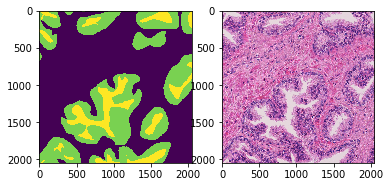

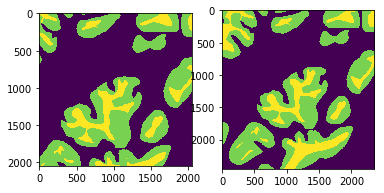

In [13]:
print(np.unique(data0['target']), data0['target'].shape, data0['input'].shape)
target = tensor2im(data0['target'], segmap=True, num_classes=3, visual=False)
input_ = tensor2im(data0['input'], segmap=False, visual=False)
print(target.shape, input_.shape)
print(np.unique(target))
tile = imageio.imread(image_paths[0])
plot_before_after(target, input_)
thetile = imageio.imread(data0['target_path'])
print(np.unique(thetile))
plot_before_after(target, thetile)

In [24]:
aida_ann_dir = '/home/andrea/Documents/Repositories/AIDA/dist/data/annotations'
aida_ann.dump_to_json(aida_ann_dir)

In [25]:
aida_ann.merge_overlapping_segments(dissimilarity_thresh=5.0, max_iter=4)
aida_ann.dump_to_json(aida_ann_dir)

2019-02-28 18:47:05,268 | INFO | ID: 6681 | Begin segment merging ...
2019-02-28 18:47:05,269 | INFO | ID: 6681 | [Layer 'epithelium'] Initial number of items is 1278.
2019-02-28 18:47:05,269 | INFO | ID: 6681 | [Layer 'epithelium'] Iter 0 begins ...
2019-02-28 18:47:09,832 | INFO | ID: 6681 | Items pairs: 0/816003 queued - 0 to merge
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/andrea/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 142, in _serve
  File "/home/andrea/anaconda3/lib/python3.7/multiprocessing/connection.py", line 453, in accept
  File "/home/andrea/anaconda3/lib/python3.7/multiprocessing/connection.py", line 598, in accept
  File "/home/andrea/anaconda3/lib/python3.7/socket.py", line 212, in accept
OSError: [Errno 24] Too many open files

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/andrea/anaconda3/lib/python3.7/site-packages/ipykernel/iostream.py

Full: 

# debug on real data
tile_path0 = '/Volumes/A-CH-EXDISK/Projects/Dataset/train/17_A047-4463_153D+-+2017-05-11+09.40.22_TissueTrain_(1.00,30774,15012,3897,4556)/tiles/17_A047-4463_153D+-+2017-05-11+09.40.22_TissueTrain_(1.00,30774,15012,3897,4556)_mask_1,2049.png'
tile_path1 = '/Volumes/A-CH-EXDISK/Projects/Dataset/train/17_A047-4463_153D+-+2017-05-11+09.40.22_TissueTrain_(1.00,30774,15012,3897,4556)/tiles/17_A047-4463_153D+-+2017-05-11+09.40.22_TissueTrain_(1.00,30774,15012,3897,4556)_mask_628,2508.png'
coords_pattern = '\((\w\.\w{1,3}),(\w{1,6}),(\w{1,6}),(\w{1,6}),(\w{1,6})\)_mask_(\w{1,6}),(\w{1,6})'
for tile_path in [tile_path0, tile_path1]:  # test on subsets of the tiles
    tile = imageio.imread(tile_path)
    coords_info = re.search(coords_pattern, Path(tile_path).name).groups()  # tuple with all matched groups
    downsample = float(coords_info[0])  # downsample is a float
    area_x, area_y, area_w, area_h, tile_x, tile_y = tuple(int(num) for num in coords_info[1:])
    x_offset = tile_x
    y_offset = tile_y
    contours, labels, boxes = converter.mask_to_contour(tile, x_offset, y_offset)
    for contour, label, box in zip(contours, labels, boxes):
        aida_ann.add_item(label, 'path', tile_rect=box)
        contour = contour.squeeze().astype(int).tolist()  # deal with extra dim at pos 1
        aida_ann.add_segments_to_last_item(contour)

# Plot contours before merging
large_image = imageio.imread('/Volumes/A-CH-EXDISK/Projects/Dataset/train/17_A047-4463_153D+-+2017-05-11+09.40.22_TissueTrain_(1.00,30774,15012,3897,4556)/17_A047-4463_153D+-+2017-05-11+09.40.22_TissueTrain_(1.00,30774,15012,3897,4556)_img.png')
epi_contours, _ = aida_ann.get_layer_points('epithelium', contour_format=True)
cv2.drawContours(large_image, epi_contours, -1, (0, 0, 0), 30)
lumen_contours, _ = aida_ann.get_layer_points('lumen', contour_format=True)
cv2.drawContours(large_image, lumen_contours, -1, (0, 250, 0), 30)
plt.figure(figsize = (10,20))
plt.imshow(large_image[2000:, 0:2800])
print(len(epi_contours), len(lumen_contours))

aida_ann.merge_overlapping_segments(dissimilarity_thresh=5.0, max_iter=3)

# Plot contours after merging
large_image = imageio.imread('/Volumes/A-CH-EXDISK/Projects/Dataset/train/17_A047-4463_153D+-+2017-05-11+09.40.22_TissueTrain_(1.00,30774,15012,3897,4556)/17_A047-4463_153D+-+2017-05-11+09.40.22_TissueTrain_(1.00,30774,15012,3897,4556)_img.png')
epi_contours, _ = aida_ann.get_layer_points('epithelium', contour_format=True)
cv2.drawContours(large_image, epi_contours, -1, (0, 0, 0), 30)
lumen_contours, _ = aida_ann.get_layer_points('lumen', contour_format=True)
cv2.drawContours(large_image, lumen_contours, -1, (0, 250, 0), 30)
plt.figure(figsize = (10,20))
plt.imshow(large_image[2000:, 0:2800])
print(len(epi_contours), len(lumen_contours))

# debug on toy data
import numpy as np
import skimage.draw as draw
from itertools import product
from collections import OrderedDict

# overwrite converter and annotation
value_hier = (0, 1)
test_label_value_map = {
                'up': 1,
                'background': 0
            }
test_label_interval_map = {
                'up': (0.1, 1),
                'background': (0, 0.1)
            }
converter = MaskConverter(value_hier=value_hier, 
                                label_value_map=test_label_value_map, 
                                label_interval_map=test_label_interval_map)
aida_ann = AnnotationBuilder('test', 'test', ['up'])

mask = np.zeros((500, 1000))
rr, cc = draw.ellipse(250, 500, 150, 200)
mask[rr, cc] = 1
plt.imshow(mask)

tile1, tile2 = mask[:, 0:500].astype(np.uint8), mask[:, 501:].astype(np.uint8)
print(tile1.dtype)

contours1, labels1, boxes1 = converter.mask_to_contour(tile1)
cnt_tile1 = mask.copy()
cv2.drawContours(cnt_tile1, contours1, -1, 50, 10)
x, y, w, h = boxes1[0]
cv2.rectangle(cnt_tile1, (x,y),(x+w,y+h), 30, 2)
plt.imshow(cnt_tile1)

contours2, labels2, boxes2 = converter.mask_to_contour(tile2, x_offset=501, y_offset=0)
cnt_tile2 = mask.copy()
cv2.drawContours(cnt_tile2, contours2, -1, 50, 10)
x, y, w, h = boxes2[0]
cv2.rectangle(cnt_tile2, (x,y), (x+w,y+h), 30, 2)
plt.imshow(cnt_tile2)

contours, labels, boxes = contours1 + contours2, labels1 + labels2, boxes1 + boxes2
for contour, label, box in zip(contours, labels, boxes):
    aida_ann.add_item(label, 'path', tile_rect=box)
    contour = contour.squeeze().astype(int).tolist()  # deal with extra dim at pos 1
    aida_ann.add_segments_to_last_item(contour)

len(aida_ann.get_layer_points('up'))

# check that boxes result as touching (partial overlap):
aida_ann.check_relative_rect_positions(boxes[1], boxes[0], eps=0.5)

# check that closest points are found correctly
points0 = tuple(tuple(point.squeeze()) for point in contours1[0])
points1 = tuple(tuple(point.squeeze()) for point in contours2[0])
closest_points, point_dist = aida_ann.find_closest_points(aida_ann.euclidean_dist, points0, points1)
print(closest_points)

# check contour merging
outer_points = aida_ann.get_merged(points0, points1, closest_points)
outer_contour = [np.array(outer_points)[:, np.newaxis, :]]
outer_cnt_tile = mask.copy()
cv2.drawContours(outer_cnt_tile, outer_contour, -1, 50, 10)
plt.imshow(outer_cnt_tile)

# Check contour merging for overlapping contours:
# overwriter converter and annotation
value_hier = (0, 1)
test_label_value_map = {
                'up': 1,
                'background': 0
            }
test_label_interval_map = {
                'up': (0.1, 1),
                'background': (0, 0.1)
            }
converter = MaskConverter(value_hier=value_hier, 
                                label_value_map=test_label_value_map, 
                                label_interval_map=test_label_interval_map)
aida_ann = AnnotationBuilder('test', 'test', ['up'])

mask = np.zeros((500, 1000))
rr, cc = draw.ellipse(250, 350, 175, 210)
mask[rr, cc] = 1
rr, cc = draw.ellipse(275, 650, 100, 180)
mask[rr, cc] = 1.1
plt.imshow(mask)

tile1, tile2 = mask[0:450, 0:600].astype(np.uint8), mask[50:, 400:].astype(np.uint8)
print(tile1.shape, tile2.shape)

contours1, labels1, boxes1 = converter.mask_to_contour(tile1, x_offset=0, y_offset=0)
cnt_mask = np.zeros((500, 1000))
cv2.drawContours(cnt_mask, contours1, -1, 90, 10)
x, y, w, h = boxes1[0]
cv2.rectangle(cnt_mask, (x,y),(x+w,y+h), 60, 2)
contours2, labels2, boxes2 = converter.mask_to_contour(tile2, x_offset=400, y_offset=50)
cnt_tile2 = mask.copy()
cv2.drawContours(cnt_mask, contours2, -1, 150, 10)
x, y, w, h = boxes2[0]
cv2.rectangle(cnt_mask, (x,y), (x+w,y+h), 250, 2)
plt.imshow(cnt_mask)

contours, labels, boxes = contours1 + contours2, labels1 + labels2, boxes1 + boxes2
for contour, label, box in zip(contours, labels, boxes):
    aida_ann.add_item(label, 'path', tile_rect=box)
    contour = contour.squeeze().astype(int).tolist()  # deal with extra dim at pos 1
    aida_ann.add_segments_to_last_item(contour)

len(aida_ann.get_layer_points('up'))

# check that boxes result as overlapping
aida_ann.check_relative_rect_positions(boxes[0], boxes[1], eps=0.5)

# remove overlapping points
points0 = tuple(tuple(point.squeeze()) for point in contours1[0])
points1 = tuple(tuple(point.squeeze()) for point in contours2[0])
points1_no_overlap = aida_ann.remove_overlapping_points(points0, points1)
tile = np.ones_like(mask)
cv2.drawContours(tile, [np.array(points0)[:,np.newaxis,:]], -1, 100, 3)
cv2.drawContours(tile, [np.array(points1_no_overlap)[:,np.newaxis,:]], -1, 250, 3)
plt.imshow(tile)

# check that closest points are found correctly
closest_points, point_dist = aida_ann.find_closest_points(aida_ann.euclidean_dist, points0, points1_no_overlap)
print(list(closest_points)[0:10])

# check contour merging
outer_points = aida_ann.get_merged(points0, points1_no_overlap, closest_points, positions='vertical')
outer_contour = [np.array(outer_points)[:, np.newaxis, :]]
outer_cnt_tile = mask.copy()
cv2.drawContours(outer_cnt_tile, outer_contour, -1, 50, 10)
plt.imshow(outer_cnt_tile)

len(points0)

len(aida_ann.get_layer_points('up'))

aida_ann.merge_overlapping_segments()

aida_final_points = aida_ann.get_layer_points('up')
final_contour = np.array(aida_final_points)[:, np.newaxis, :]
cnt_tile = mask.copy()
cv2.drawContours(cnt_tile, final_contour, -1, 50, 10)
plt.imshow(cnt_tile)